## Import Statements
The notebook was developed on Keras using the Tensorflow 2.2.0 backend.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from tensorflow.keras.callbacks import CSVLogger
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import glob
import os
import json
import umap

## Hardware Configuration
Check for GPU and allow memory growth such that limitations for training are reduced. 

In [2]:
if len(tf.config.experimental.get_visible_devices('GPU')):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Functionality
The following functionality helps to create the images for training the registration task.

## Model parameters
The grid dimensions have to be know, as well as the image dimensions for scaling. The depth of the input and output layer is 2 here, as we will have one channel representing x-coordinates and a second channel representing y-coordinates. 

In [3]:
grid_width = 18
grid_height = 18

image_width = 728
image_height = 728

inout_layers = 2

## Functionality

In [4]:
def get_xy_position(base_path):
    def sort_key(path):
        return int(path.split(os.sep)[-1].split(".")[0].split("_")[0]) 

    globs = glob.glob(base_path+'/*.json')
    files = sorted(globs, key=sort_key)

    file_length =len(files)
    xy_position = np.full((file_length, grid_height * grid_width * 2), 0)

    counter = 0
    for file in files:
        with open(file) as json_file:
            data = json.load(json_file)

            file_id = int(file.split(os.sep)[-1].split(".")[0].split("_")[0])

            for key, value in data.items():
                key = int(key)

                xy_position[counter][key*2] = value[0]
                xy_position[counter][key*2+1] = value[1]

            counter += 1
    return xy_position

## Prepare data
Load the data and scale them to be between 0.0 an 1.0. Further use zero-padding to get a 20x20 shape for this example. We use the already augmented data here for providing a large training set.

In [48]:
xy_position_train = get_xy_position('/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2VGN/train')
xy_position_val = get_xy_position('/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/validation')
xy_position_test = get_xy_position('/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/test')
xy_position_augmentation = get_xy_position('/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2A/train')

In [36]:
#xy_position_augmentation = xy_position_augmentation[0:800]

In [49]:
xy_position_concat = np.concatenate((xy_position_train, xy_position_val, xy_position_test, xy_position_augmentation))

In [38]:
xy_position_concat.shape

(1680, 648)

# TSNE

In [20]:
manifold = TSNE(n_iter=2000, perplexity=50)
tsne_features = manifold.fit_transform(xy_position_concat)

In [21]:
train_size = len(xy_position_train)

<ipython-input-22-a4c767904249>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


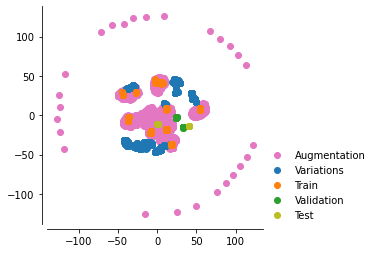

In [22]:
plt.scatter(tsne_features[train_size+80:, 0], tsne_features[train_size+80:, 1], c='tab:pink', label='Augmentation')
plt.scatter(tsne_features[160:train_size, 0], tsne_features[160:train_size, 1], c='tab:blue', label='Variations')
plt.scatter(tsne_features[0:160, 0], tsne_features[0:160, 1], c='tab:orange', label='Train')
plt.scatter(tsne_features[train_size:train_size+40, 0], tsne_features[train_size:train_size+40, 1], c='tab:green', label='Validation')
plt.scatter(tsne_features[train_size+40:train_size+80, 0], tsne_features[train_size+40:train_size+80, 1], c='tab:olive', label='Test')

plt.axes().set_aspect('equal')
plt.legend(loc=(1.0, 0.0), frameon=False)
plt.gca().spines['left'].set_position(('outward', 5))
plt.gca().spines['bottom'].set_position(('outward', 5))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig("manifold.png", dpi=300)

# UMAP

In [43]:
reducer = umap.UMAP()

In [44]:
embedding = reducer.fit_transform(xy_position_concat)

/home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [45]:
tsne_features = embedding
train_size = len(xy_position_train)

<ipython-input-47-6f22919612c5>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


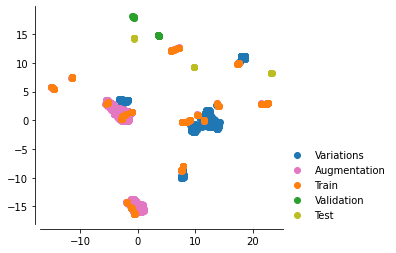

In [47]:
plt.scatter(tsne_features[160:train_size, 0], tsne_features[160:train_size, 1], c='tab:blue', label='Variations')
plt.scatter(tsne_features[train_size+80:, 0], tsne_features[train_size+80:, 1], c='tab:pink', label='Augmentation')
plt.scatter(tsne_features[0:160, 0], tsne_features[0:160, 1], c='tab:orange', label='Train')
plt.scatter(tsne_features[train_size:train_size+40, 0], tsne_features[train_size:train_size+40, 1], c='tab:green', label='Validation')
plt.scatter(tsne_features[train_size+40:train_size+80, 0], tsne_features[train_size+40:train_size+80, 1], c='tab:olive', label='Test')


plt.axes().set_aspect('equal')
plt.legend(loc=(1.0, 0.0), frameon=False)
plt.gca().spines['left'].set_position(('outward', 5))
plt.gca().spines['bottom'].set_position(('outward', 5))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# MDS

In [51]:
manifold = MDS(metric=False)#max_iter=100, n_init=1, n_jobs=6)
tsne_features = manifold.fit_transform(xy_position_concat)
train_size = len(xy_position_train)

<ipython-input-53-59d42084ebf9>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


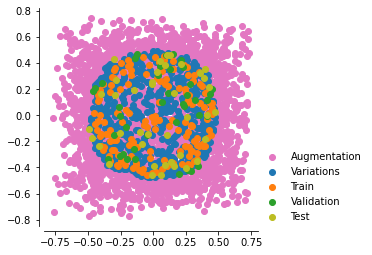

In [53]:
plt.scatter(tsne_features[train_size+80:, 0], tsne_features[train_size+80:, 1], c='tab:pink', label='Augmentation')

plt.scatter(tsne_features[160:train_size, 0], tsne_features[160:train_size, 1], c='tab:blue', label='Variations')

plt.scatter(tsne_features[0:160, 0], tsne_features[0:160, 1], c='tab:orange', label='Train')

plt.scatter(tsne_features[train_size:train_size+40, 0], tsne_features[train_size:train_size+40, 1], c='tab:green', label='Validation')
plt.scatter(tsne_features[train_size+40:train_size+80, 0], tsne_features[train_size+40:train_size+80, 1], c='tab:olive', label='Test')


plt.axes().set_aspect('equal')
plt.legend(loc=(1.0, 0.0), frameon=False)
plt.gca().spines['left'].set_position(('outward', 5))
plt.gca().spines['bottom'].set_position(('outward', 5))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)